In [87]:
%pip install google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client

Note: you may need to restart the kernel to use updated packages.


In [10]:
%pip install isodate

     ---------------------------------------- 0.0/41.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/41.7 kB ? eta -:--:--
     --------- ------------------------------ 10.2/41.7 kB ? eta -:--:--
     ------------------ ------------------- 20.5/41.7 kB 330.3 kB/s eta 0:00:01
     --------------------------- ---------- 30.7/41.7 kB 325.1 kB/s eta 0:00:01
     -------------------------------------- 41.7/41.7 kB 251.9 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [97]:
%pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/f5/b0/247159f61c5d5d6647171bef84430b7efad4db504f0229674024f3a4f7f2/wordcloud-1.9.3-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   --- ----------------------------------- 30.7/300.2 kB 330.3 kB/s eta 0:00:01
   ------- ------------------------------- 61.4/300.2 kB 544.7 kB/s eta 0:00:01
   -------------- ----------------------- 112.6/300.2 kB 819.2 kB/s eta 0:00:01
   --------------- ---------------------- 122.9/300.2 kB 722.1 kB/s eta 0:00:01
   ---------------------- --------------- 174.1/300.2 kB 807.1 kB/s eta 0:00:01
   ---------------------------- --------- 225.3/300.2 kB 860.2 kB/s eta 0:00:01
   -------------------------------- ----- 256.0/300.2 kB 927.4 kB/s eta 0:00:01
   -----------

In [242]:
import os
import google.auth
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
import pandas as pd
from bs4 import BeautifulSoup, SoupStrainer
import csv
import isodate
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\otaku\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\otaku\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [149]:
#Here is the authentication process of the YouTube Data API v3
CLIENT_ID = '193400336603-mr8u8nfdc8mdv1t7g5qlfuh7mls8of0g.apps.googleusercontent.com'
CLIENT_SECRET = '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'

# Scopes define the access level your application is requesting
SCOPES = ['https://www.googleapis.com/auth/youtube.readonly']
def authenticate():
    flow = InstalledAppFlow.from_client_secrets_file(
        'C:/Users/otaku/Downloads/client_secret_193400336603-mr8u8nfdc8mdv1t7g5qlfuh7mls8of0g.apps.googleusercontent.com.json',  # Replace with the path to your downloaded client_secret.json
        scopes=SCOPES
    )
    credentials = flow.run_local_server(port=8081)

    return credentials

# Call the authenticate function to get credentials
credentials = authenticate()

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=193400336603-mr8u8nfdc8mdv1t7g5qlfuh7mls8of0g.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8081%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.readonly&state=siRs3U16QokjDnmALAr6Ydp8C0JbQt&access_type=offline


In [ ]:
#Below is a small scale test of using and learning the API calls and functions, I was able to get a dataframe from a YouTube Playlist
def get_category_title(youtube, category_id):
    category_response = youtube.videoCategories().list(
        part='snippet',
        id=category_id
    ).execute()

    return category_response['items'][0]['snippet']['title'] if category_response['items'] else ''

# Build the YouTube API service
youtube = build('youtube', 'v3', credentials=credentials)

# Get the ID of the watch history playlist
playlist_response = youtube.playlists().list(
    part='snippet',
    mine=True
).execute()
watch_history_playlist_id = None
for playlist in playlist_response['items']:
    if playlist['snippet']['title'] == 'Actu wtch latr':
        watch_history_playlist_id = playlist['id']
        break

if watch_history_playlist_id is not None:
    # Get the videos in the watch history playlist
    playlist_items_response = youtube.playlistItems().list(
        part='snippet',
        playlistId=watch_history_playlist_id,
        maxResults=50  # Adjust as needed
    ).execute()

    video_data_list = []

    for playlist_item in playlist_items_response['items']:
        video_id = playlist_item['snippet']['resourceId']['videoId']
        
        # Get video details using the video ID
        video_response = youtube.videos().list(
            part='snippet,contentDetails,status,statistics,topicDetails',
            id=video_id
        ).execute()
        
        # Extract relevant information from the video response
        video_data = {
            'id': video_response['items'][0]['id'],
            'publishDate': video_response['items'][0]['snippet']['publishedAt'],
            'channelTitle': video_response['items'][0]['snippet']['channelTitle'],
            'tags': video_response['items'][0]['snippet'].get('tags', []),
            'categories': get_category_title(youtube, video_response['items'][0]['snippet'].get('categoryId', '')),
            'duration': video_response['items'][0]['contentDetails'].get('duration', ''),
            'viewCount': video_response['items'][0]['statistics'].get('viewCount', 0),
            'likeCount': video_response['items'][0]['statistics'].get('likeCount', 0),
            'commentCount': video_response['items'][0]['statistics'].get('commentCount', 0),
            'topicCategories': video_response['items'][0]['topicDetails'].get('topicCategories', []),
        }
        
        video_data_list.append(video_data)

    # Create a DataFrame from the list of video data
    video_df = pd.DataFrame(video_data_list)
    
    # Print the DataFrame
    display(video_df)

,id,publishDate,channelTitle,tags,categories,duration,viewCount,likeCount,commentCount,topicCategories
0,VIP6-33Ukvw,2020-03-23T19:34:57Z,ConnorFranta,"[ConnorFranta, Connor Franta, vlog, vlogging, ...",People & Blogs,PT11M41S,156201,11179,724,"[https://en.wikipedia.org/wiki/Food, https://e..."
1,yUFMmxuzQZI,2020-03-22T12:00:37Z,Brandon Rogers,[],Comedy,PT12M49S,2868662,155781,10791,"[https://en.wikipedia.org/wiki/Entertainment, ..."
2,HDU6T8LWaYA,2020-03-23T15:23:01Z,Sykkuno,"[league of legends, lol, sykkuno, league, chal...",Gaming,PT10M28S,168295,6190,140,"[https://en.wikipedia.org/wiki/Action_game, ht..."
3,0elWk-NiM-U,2023-04-23T20:59:41Z,Rarran,"[hearthstone, card game, new expansion hearths...",Gaming,PT19M39S,307567,5240,347,[https://en.wikipedia.org/wiki/Action-adventur...


In [ ]:
#Here is the cell that creates a csv file out of all the video ID's scraped from the video URL's from the HTML file containing my youtube watch history acquired by Google Takeout

# Replace 'your_html_file.html' with the actual path to your HTML file
html_file_path = 'C:/Users/otaku/OneDrive/Desktop/Takeout/YouTube ve YouTube Music/geçmiş/izleme geçmişi.html'

# Define the relevant parts to parse
only_a_tags = SoupStrainer('a', href=lambda href: href and 'youtube.com/watch?v=' in href)

# Read HTML content from the file
with open(html_file_path, 'r', encoding='utf-8') as file:
    html_content = file.read()

# Use the lxml parser and only parse relevant parts
soup = BeautifulSoup(html_content, 'lxml', parse_only=only_a_tags)

# Extract video IDs
video_ids = set(video_url.split('=')[-1] for video_url in [link['href'] for link in soup.find_all('a')])

# Specify the CSV file path
csv_file_path = 'C:/Users/otaku/OneDrive/Desktop/a/youtube_video_ids.csv'

# Load existing video IDs from the CSV file (if it exists)
existing_video_ids = set()
if os.path.exists(csv_file_path):
    with open(csv_file_path, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        existing_video_ids.update(row['Youtube Video ID'] for row in reader)

# Combine existing and new video IDs and remove duplicates
unique_video_ids = existing_video_ids.union(video_ids)

# Write all unique video IDs to the CSV file
with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['Youtube Video ID']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for video_id in unique_video_ids:
        writer.writerow({'Youtube Video ID': video_id})

print(f'Video IDs have been extracted and saved to {csv_file_path} without duplicates.')


Video IDs have been extracted and saved to C:/Users/otaku/OneDrive/Desktop/a/youtube_video_ids.csv without duplicates.


In [150]:
def get_category_title(youtube, category_id):
    category_response = youtube.videoCategories().list(
        part='snippet',
        id=category_id
    ).execute()

    return category_response['items'][0]['snippet']['title'] if category_response['items'] else ''

# Build the YouTube API service
youtube = build('youtube', 'v3', credentials=credentials)


In [5]:
#Out of the created csv file, these functions request resource records of the video that with the matching ID's from the csv file

def get_video_details_from_csv(youtube, csv_file_path):
    # Read video IDs from the CSV file
    video_list = []
    with open(csv_file_path, 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Assuming the video IDs are in the first column of the CSV file
            video_list.append(row[0])

    # Call the existing get_video_details function with the retrieved video_list
    return get_video_details(youtube, video_list)

def get_video_details(youtube, video_list):
    stats_list = []

    # Can only get 50 videos at a time.
    for i in range(0, len(video_list), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=video_list[i:i+50]
        )

        data = request.execute()
        for video in data['items']:
            title = video['snippet']['title']
            channel_title = video['snippet']['channelTitle']
            published = video['snippet']['publishedAt']
            tags = video['snippet'].get('tags', [])
            tag_count = len(tags)
            duration = video['contentDetails'].get('duration', '')
            categories = get_category_title(youtube, video['snippet'].get('categoryId', ''))
            view_count = video['statistics'].get('viewCount', 0)
            like_count = video['statistics'].get('likeCount', 0)
            comment_count = video['statistics'].get('commentCount', 0)
            stats_dict = dict(title=title, channel_title=channel_title,  published=published, tags=tags, tag_count=tag_count, duration=duration, categories=categories, view_count=view_count, like_count=like_count, comment_count=comment_count)
            stats_list.append(stats_dict)

    return stats_list

# Example usage:
# Assuming youtube is your YouTube API object and 'video_ids.csv' is your CSV file
result = get_video_details_from_csv(youtube, 'C:/Users/otaku/OneDrive/Desktop/a/videos_5000.csv')

In [226]:
#Through the formatting of result, we can easily make a dataframe out of it

df = pd.DataFrame(result)
df.to_csv('C:/Users/otaku/OneDrive/Desktop/a/dataframe.csv', index=False)

In [227]:
df.head()

,title,channel_title,published,tags,tag_count,duration,categories,view_count,like_count,comment_count
0,"Clockwork, Reckless Apprentice & Majordomo",Danehearth,2021-04-08T21:19:09Z,"[Hearthstone, DaneHearth, Dane Hearthstone, Wi...",7,PT15M28S,Gaming,31482,1500,103
1,Cleaning up my uranium waste,NileBlue,2020-02-23T20:52:48Z,"[nile, red, science, chemistry, uranium, waste...",11,PT5M40S,Science & Technology,1907011,60767,4164
2,Space Dandy - Welcome to the X Dimension [Endi...,peter rubi,2014-02-20T09:31:00Z,"[Anime (TV Genre), music, Space Dandy, Sub]",4,PT2M50S,Music,640356,12672,797
3,Yeni Finish Parlatıcı-Kurutucu ile 2 kata kada...,Finish Türkiye,2022-09-20T09:19:13Z,[],0,PT16S,Entertainment,5476784,0,0
4,PewDiePie Explains his Tattoos,Cold Ones Clips,2019-07-13T19:00:02Z,"[maxmoefoe, anything4views, cold ones, highlig...",7,PT3M3S,People & Blogs,1279270,49625,1418


In [228]:
# Convert count columns to numeric
numeric_cols = ['view_count', 'like_count', 'comment_count']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)


In [229]:
# convert duration to seconds
df['duration_sec'] = df['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())
df.head()[['duration_sec', 'duration']] 

,duration_sec,duration
0,928.0,PT15M28S
1,340.0,PT5M40S
2,170.0,PT2M50S
3,16.0,PT16S
4,183.0,PT3M3S


In [230]:
#Getting rid of videos(rows) wit both like_count comment_count values 0, since they are most likely ads
df_noAds = df.loc[(df['like_count'] != 0) | (df['comment_count'] != 0)]
df_noAds.head()

,title,channel_title,published,tags,tag_count,duration,categories,view_count,like_count,comment_count,duration_sec
0,"Clockwork, Reckless Apprentice & Majordomo",Danehearth,2021-04-08T21:19:09Z,"[Hearthstone, DaneHearth, Dane Hearthstone, Wi...",7,PT15M28S,Gaming,31482,1500,103,928.0
1,Cleaning up my uranium waste,NileBlue,2020-02-23T20:52:48Z,"[nile, red, science, chemistry, uranium, waste...",11,PT5M40S,Science & Technology,1907011,60767,4164,340.0
2,Space Dandy - Welcome to the X Dimension [Endi...,peter rubi,2014-02-20T09:31:00Z,"[Anime (TV Genre), music, Space Dandy, Sub]",4,PT2M50S,Music,640356,12672,797,170.0
4,PewDiePie Explains his Tattoos,Cold Ones Clips,2019-07-13T19:00:02Z,"[maxmoefoe, anything4views, cold ones, highlig...",7,PT3M3S,People & Blogs,1279270,49625,1418,183.0
5,When Ornn Upgrades an Item in Season 11,Vandiril,2020-10-02T00:40:42Z,"[vandiril, ornn upgrade, season 11, preseason ...",10,PT2M45S,Gaming,782715,14796,948,165.0


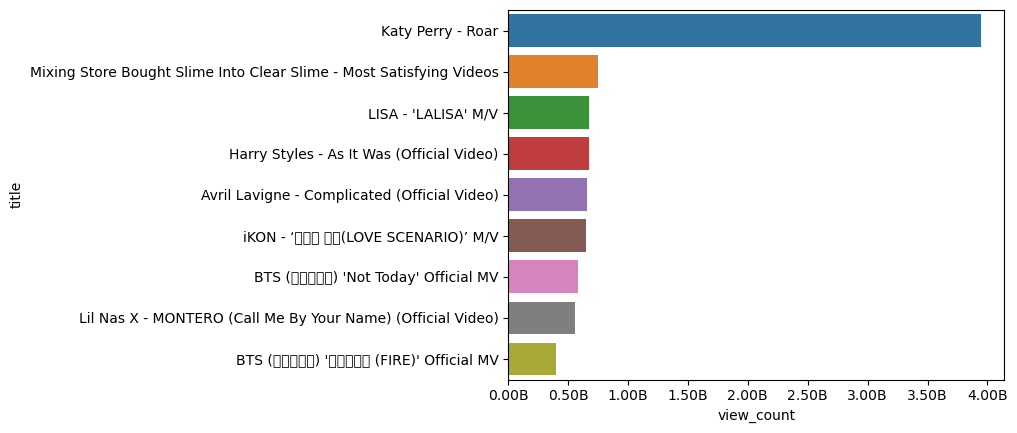

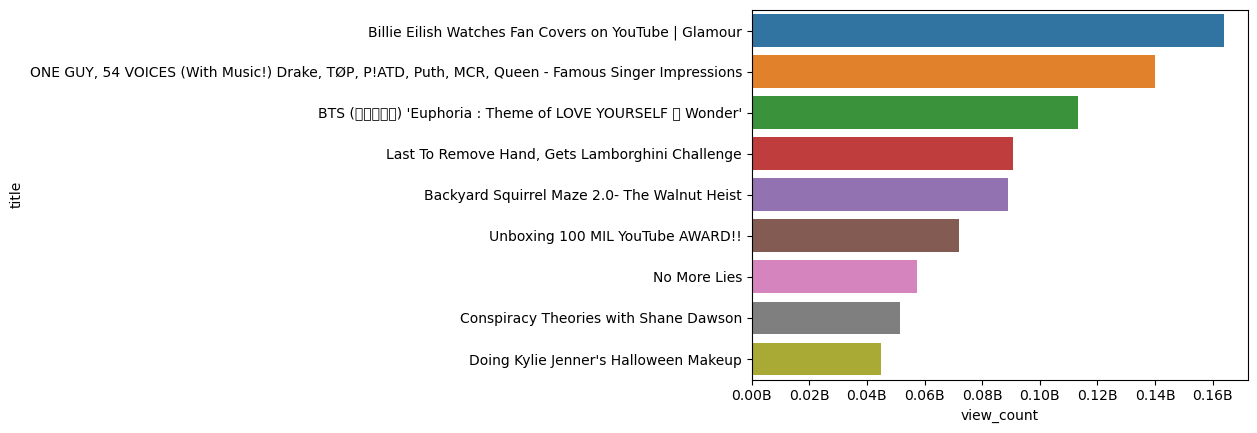

In [231]:
# Redirect warnings to null
warnings.simplefilter("ignore")

ax = sns.barplot(x='view_count', y='title', data=df.sort_values('view_count', ascending=False)[0:9])

# Rotate y-axis labels
plot = ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Rotation is optional for y-axis labels

# Format x-axis labels
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(float(x)/1000000000) + 'B'))


# Show the plot
plt.show()

df_longer = df[df['duration_sec'] > 500]
# Create the bar plot with swapped x and y axes
ax = sns.barplot(x='view_count', y='title', data=df_longer.sort_values('view_count', ascending=False)[0:9])

# Rotate y-axis labels
plot = ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Rotation is optional for y-axis labels

# Format x-axis labels
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(float(x)/1000000000) + 'B'))


# Show the plot
plt.show()


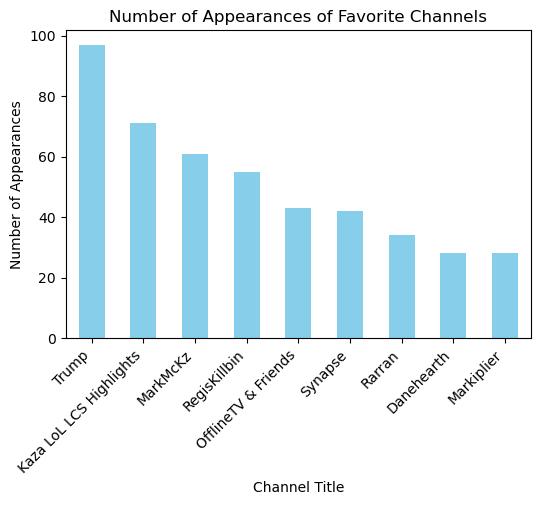

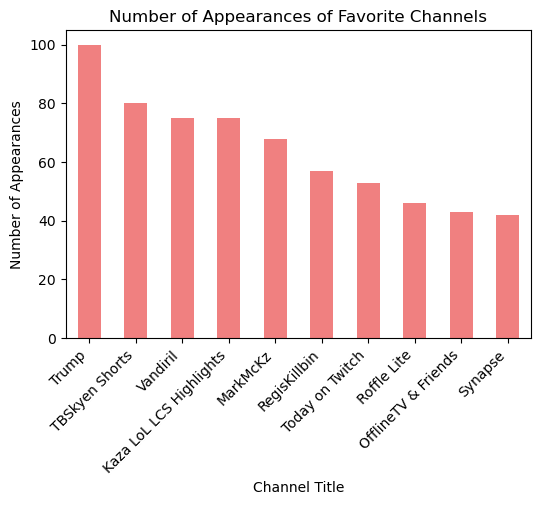

In [232]:

# Count occurrences of each unique channel_title where duration_sec > 300
channel_title_counts = df[df['duration_sec'] > 300]['channel_title'].value_counts()

# Filter the channel titles that appear more than 25 times
popular_channel_titles = channel_title_counts[channel_title_counts > 25]

# Plotting the bar chart
plt.figure(figsize=(6, 4))
popular_channel_titles.plot(kind='bar', color='skyblue')
plt.xlabel('Channel Title')
plt.ylabel('Number of Appearances')
plt.title('Number of Appearances of Favorite Channels')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

# Count occurrences of each unique channel_title where duration_sec > 300
channel_title_counts = df['channel_title'].value_counts()

# Filter the channel titles that appear more than 25 times
popular_channel_titles = channel_title_counts[channel_title_counts > 35]

# Plotting the bar chart
plt.figure(figsize=(6, 4))
popular_channel_titles.plot(kind='bar', color='lightcoral')
plt.xlabel('Channel Title')
plt.ylabel('Number of Appearances')
plt.title('Number of Appearances of Favorite Channels')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()



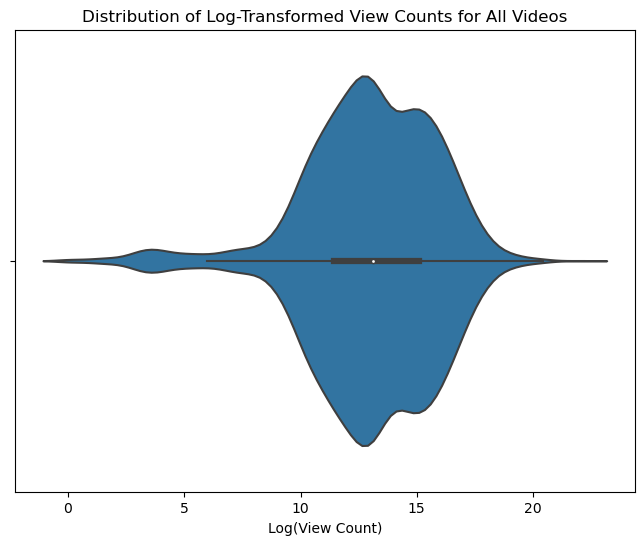

In [233]:
# Log-transform the 'view_count'
df['log_view_count'] = np.log1p(df['view_count'])  # Adding 1 to avoid log(0)

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x=df['log_view_count'])

# Set plot labels and title
plt.xlabel('Log(View Count)')
plt.title('Distribution of Log-Transformed View Counts for All Videos')

# Show the plot
plt.show()

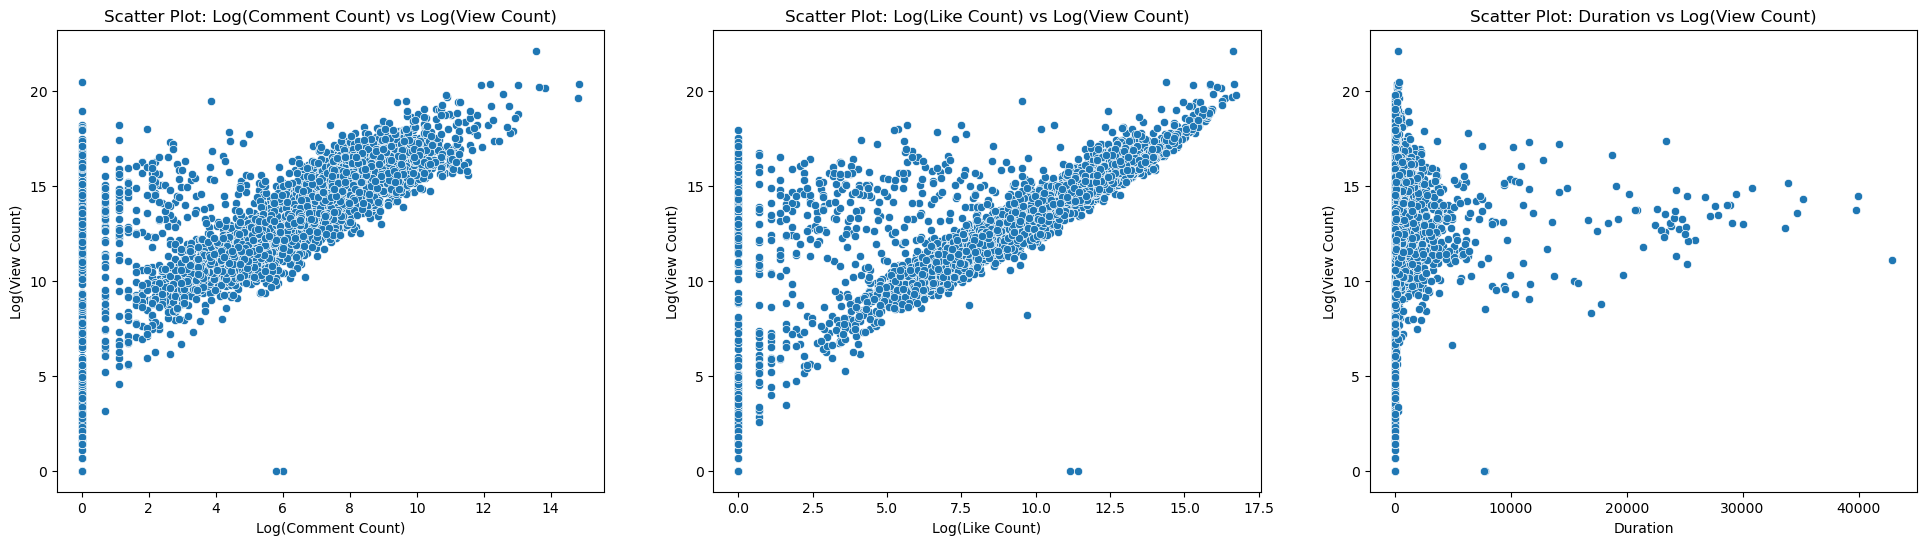

In [234]:
# Convert 'comment_count' and 'like_count' to numeric (as they might be stored as strings)
df['comment_count'] = pd.to_numeric(df['comment_count'], errors='coerce')
df['like_count'] = pd.to_numeric(df['like_count'], errors='coerce')

# Log-transform 'comment_count' and 'like_count'
df['log_comment_count'] = np.log1p(df['comment_count'])
df['log_like_count'] = np.log1p(df['like_count'])

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(24, 6))

# Scatter plot for 'comment_count' vs 'view_count'
sns.scatterplot(data=df, x='log_comment_count', y='log_view_count', ax=ax[0])
ax[0].set_xlabel('Log(Comment Count)')
ax[0].set_ylabel('Log(View Count)')
ax[0].set_title('Scatter Plot: Log(Comment Count) vs Log(View Count)')

# Scatter plot for 'like_count' vs 'view_count'
sns.scatterplot(data=df, x='log_like_count', y='log_view_count', ax=ax[1])
ax[1].set_xlabel('Log(Like Count)')
ax[1].set_ylabel('Log(View Count)')
ax[1].set_title('Scatter Plot: Log(Like Count) vs Log(View Count)')

sns.scatterplot(data=df, x='duration_sec', y='log_view_count', ax=ax[2])
ax[2].set_xlabel('Duration')
ax[2].set_ylabel('Log(View Count)')
ax[2].set_title('Scatter Plot: Duration vs Log(View Count)')

# Show the plots
plt.show()

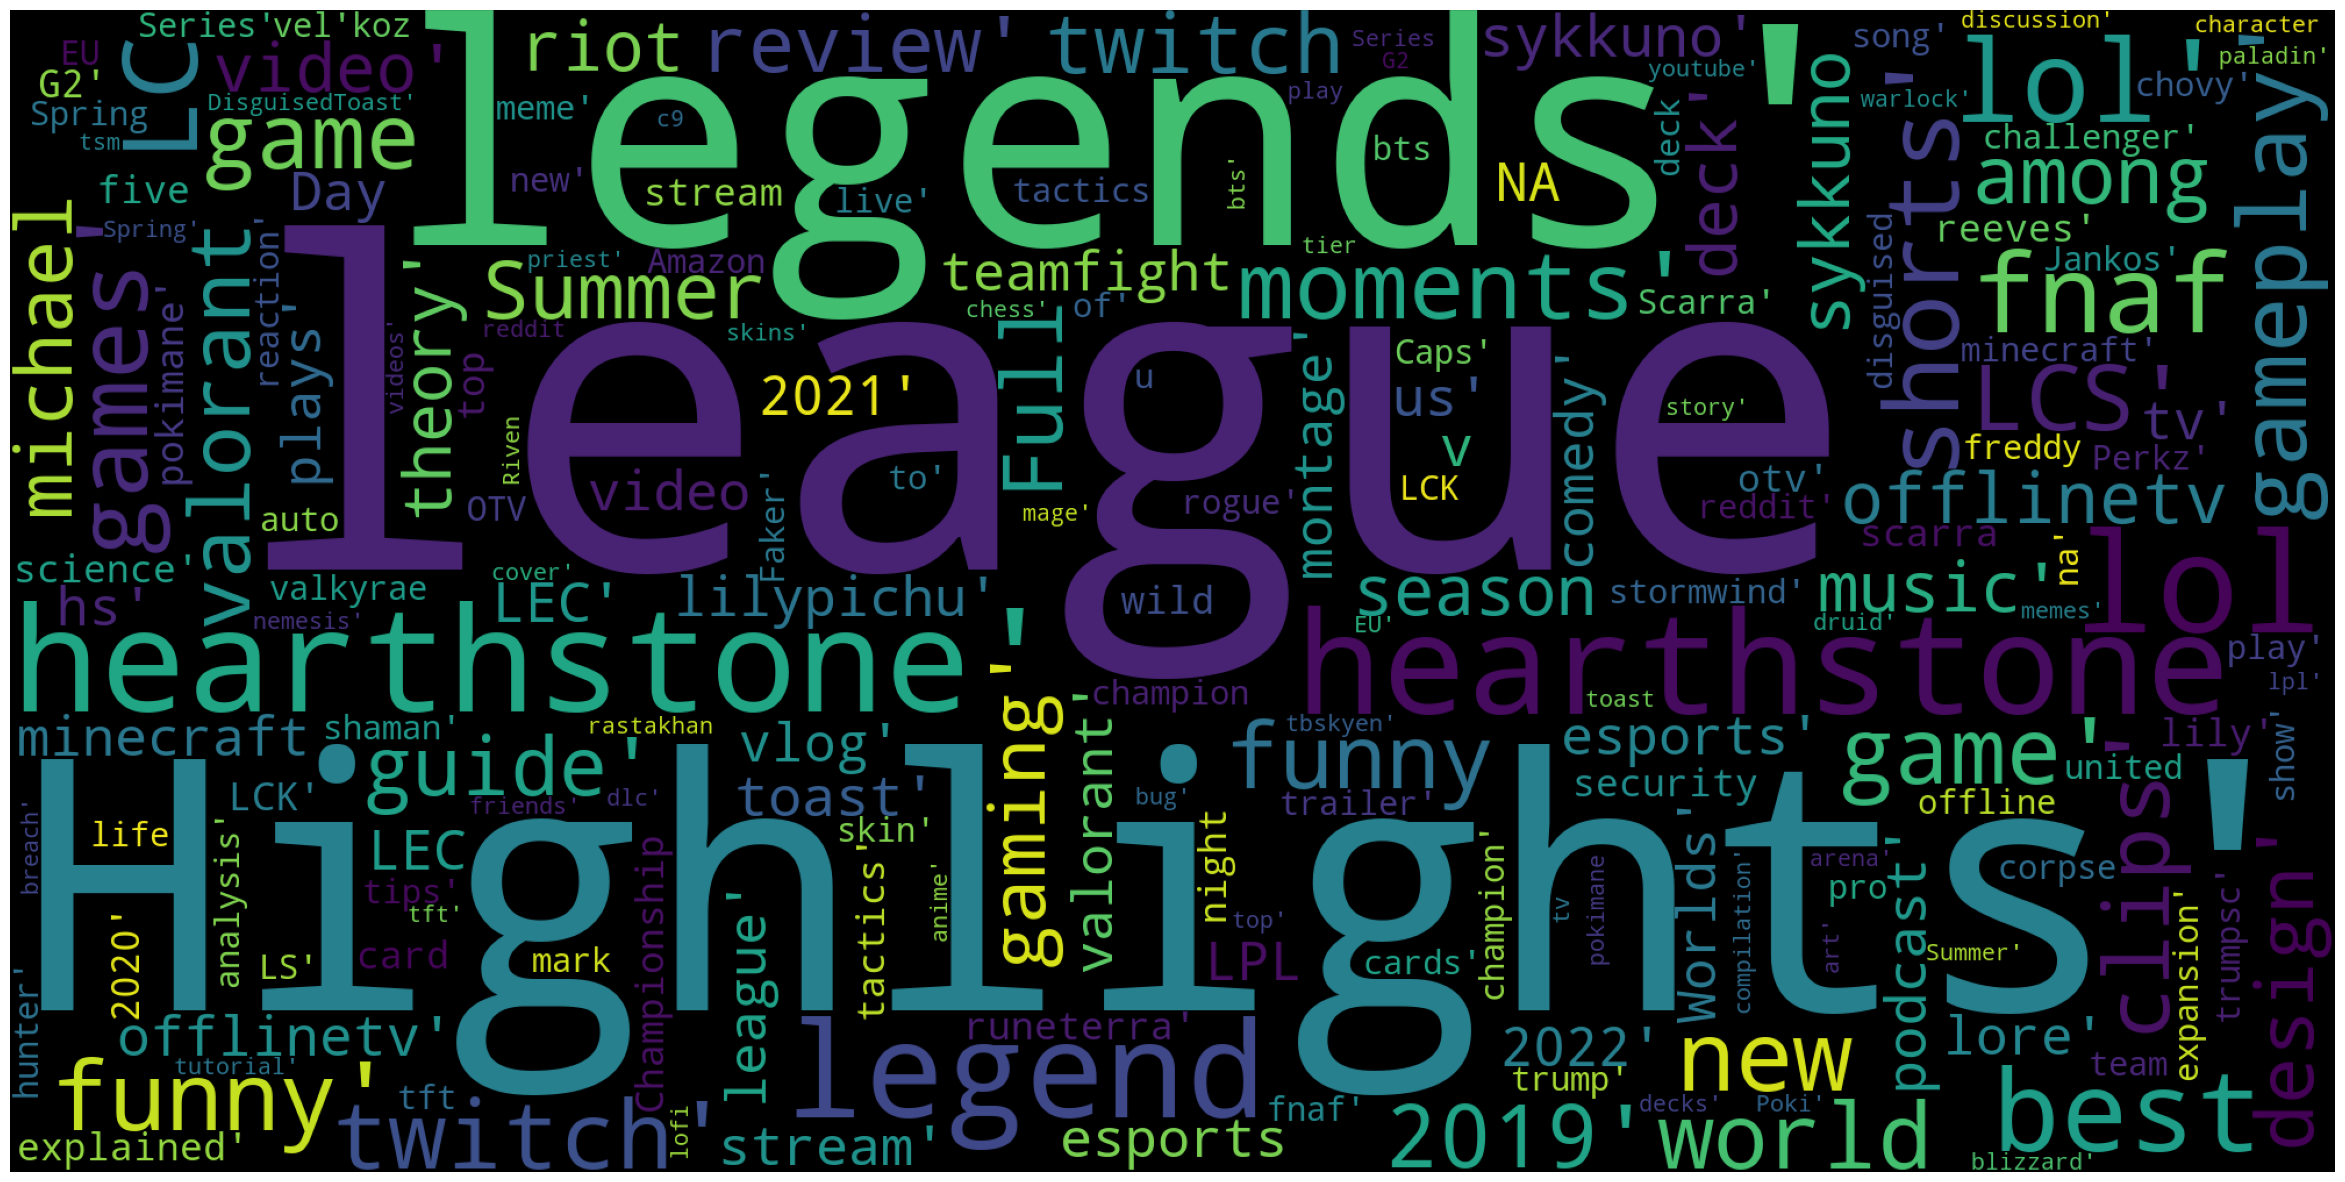

In [101]:
stop_words = set(stopwords.words('english'))
df['tags_no_stopwords'] = df['tags'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_tags = list([a for b in df['tags_no_stopwords'].tolist() for a in b])
all_tags_str = ' '.join(all_tags) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off")

wordcloud = WordCloud(width=2000, height=1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_tags_str)
plot_cloud(wordcloud)

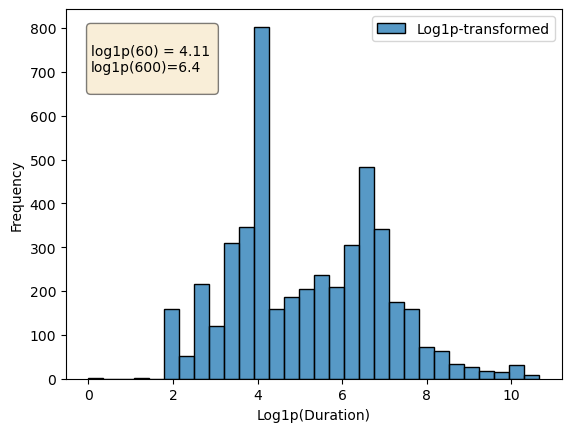

In [235]:
df['log1p_duration_sec'] = np.log1p(df['duration_sec'])

# Plot the histogram
sns.histplot(data=df, x='log1p_duration_sec', bins=30, kde=False, label='Log1p-transformed')

# Add labels and a legend
plt.xlabel('Log1p(Duration)')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Add information text box
info_text = """
log1p(60) = 4.11 \nlog1p(600)=6.4
"""
plt.text(0.05, 0.95, info_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Show the plot
plt.show()

In [151]:
def get_subscriptions(youtube):

    subscribed_channels = []
    next_page_token = None

    while True:
        # Get the channels that the authenticated user is subscribed to
        subscriptions_response = youtube.subscriptions().list(
            part='snippet',
            mine=True,
            maxResults=50,  # Adjust as needed, max is 50
            pageToken=next_page_token
        ).execute()

        # Extract channel information from the response
        subscriptions = subscriptions_response.get('items', [])

        for subscription in subscriptions:
            channel_title = subscription['snippet']['title']
            subscribed_channels.append(channel_title)

        next_page_token = subscriptions_response.get('nextPageToken')

        if not next_page_token:
            break  # No more pages

    return subscribed_channels

In [152]:
subscribed_channels = get_subscriptions(youtube)

In [236]:
df['channel_occurrence'] = df['channel_title'].map(df['channel_title'].value_counts())

df['subscribed'] = df['channel_title'].isin(subscribed_channels).astype(int)

data = {
    'title_length': df['title'].apply(len),
    'channel_occurrence': df['channel_occurrence'],
    'published': pd.to_datetime(df['published']),
    'tag_count': df['tag_count'],
    'categories': df['categories'],
    'view_count': df['view_count'],
    'like_count': df['like_count'],
    'comment_count': df['comment_count'],
    'duration_sec': df['duration_sec'],
    'subscribed': df['subscribed']
}

new_df = pd.DataFrame(data)
new_df = new_df[(new_df['like_count'] != 0) & (new_df['comment_count'] != 0)]
# Print or use new_df for machine learning models
new_df

,title_length,channel_occurrence,published,tag_count,categories,view_count,like_count,comment_count,duration_sec,subscribed
0,42,29,2021-04-08 21:19:09+00:00,7,Gaming,31482,1500,103,928.0,0
1,28,3,2020-02-23 20:52:48+00:00,11,Science & Technology,1907011,60767,4164,340.0,0
2,67,1,2014-02-20 09:31:00+00:00,4,Music,640356,12672,797,170.0,0
4,30,2,2019-07-13 19:00:02+00:00,7,People & Blogs,1279270,49625,1418,183.0,0
5,39,75,2020-10-02 00:40:42+00:00,10,Gaming,782715,14796,948,165.0,0
...,...,...,...,...,...,...,...,...,...,...
4732,35,35,2022-08-24 14:55:24+00:00,22,Gaming,98519,2892,148,685.0,1
4733,41,4,2023-11-29 19:00:47+00:00,6,Entertainment,277405,10470,1101,2916.0,0
4735,57,1,2020-09-06 08:12:02+00:00,32,Howto & Style,30824,486,31,319.0,0
4736,41,53,2021-09-28 13:58:52+00:00,16,Gaming,38168,317,18,38.0,0


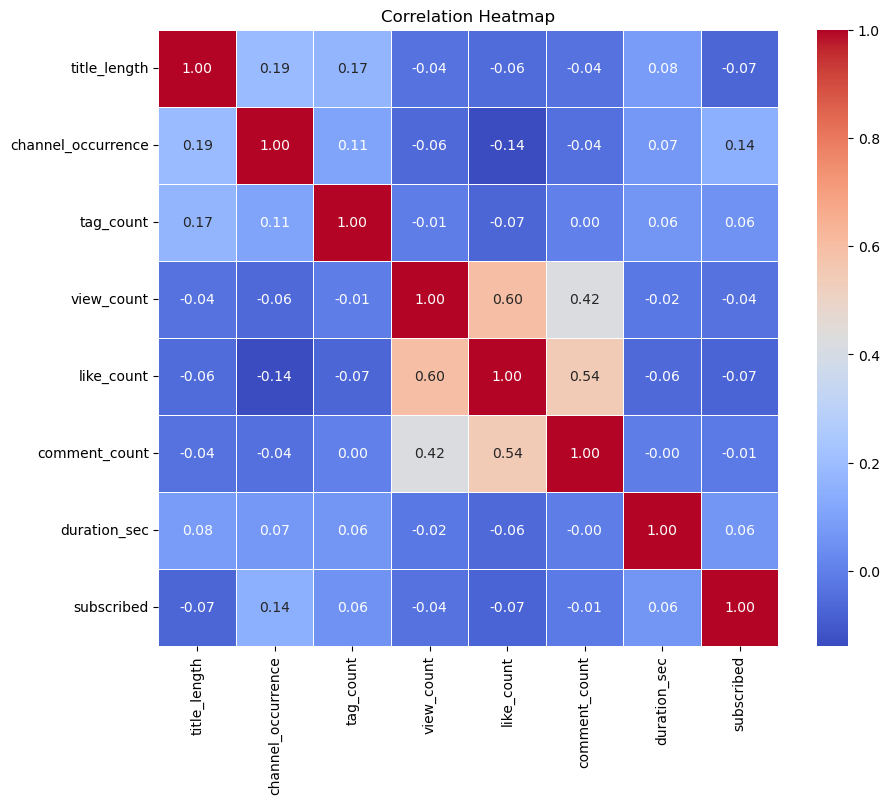

In [238]:
numeric_columns = new_df.select_dtypes(include='number')

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [244]:
# Assuming new_df is your DataFrame
# Features (X) include all columns except 'subscribed'
X = new_df.drop('subscribed', axis=1)

# Encode 'categories'
X = pd.get_dummies(X, columns=['categories'], drop_first=True)

# Extract relevant information from 'published'
X['published_year'] = new_df['published'].dt.year
X['published_month'] = new_df['published'].dt.month
X['published_day'] = new_df['published'].dt.day
X['published_hour'] = new_df['published'].dt.hour
X = X.drop(['published'], axis=1)

# Target variable (y) is 'subscribed'
y = new_df['subscribed']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest model with class_weight='balanced'
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

cv_scores = cross_val_score(rf_model, X, y, cv=5)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Predictions on the test set
rf_y_pred = rf_model.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)
rf_class_report = classification_report(y_test, rf_y_pred)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean()}")
print("---------------------------")
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Random Forest Confusion Matrix:\n{rf_conf_matrix}")
print(f"Random Forest Classification Report:\n{rf_class_report}")


Cross-Validation Scores: [0.93846154 0.94201183 0.92544379 0.93136095 0.93127962]
Mean Cross-Validation Score: 0.9337115454723912
---------------------------
Random Forest Accuracy: 0.9384615384615385
Random Forest Confusion Matrix:
[[688   5]
 [ 47 105]]
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       693
           1       0.95      0.69      0.80       152

    accuracy                           0.94       845
   macro avg       0.95      0.84      0.88       845
weighted avg       0.94      0.94      0.93       845



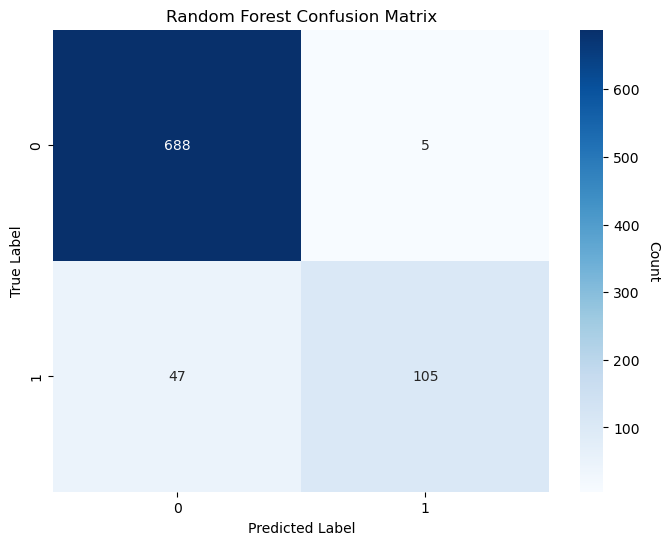

In [245]:
# Assuming rf_conf_matrix is the confusion matrix from your Random Forest Classifier
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add color bar with linear scale
cbar = heatmap.collections[0].colorbar
cbar.set_label('Count', rotation=270, labelpad=15)

plt.show()

